### Entyty-Relationship Diagram

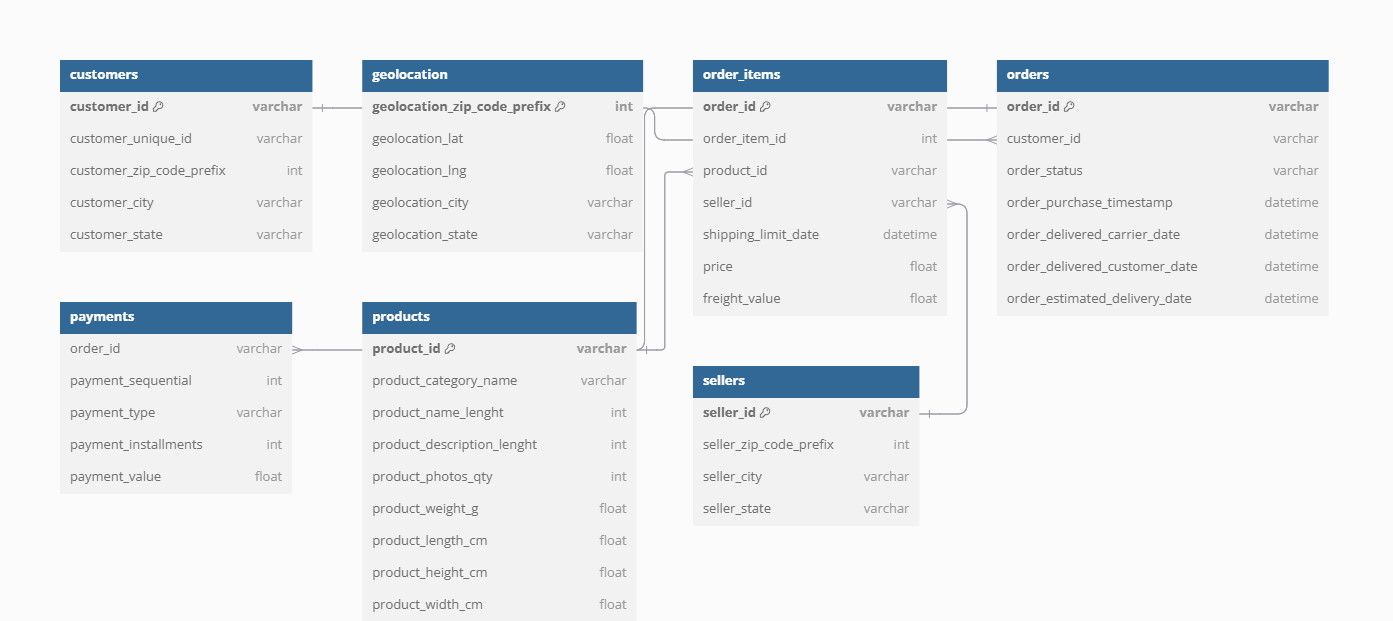

In [1]:


from IPython.display import Image
Image(filename="C:/Users/Acer/OneDrive/Зображення/ERD_e-Comm(target).png")

# **Sales & Revenue & Payments Analysis**

## 1. Product Category Performance

### *Which product categories have the highest profit margins?*

In [34]:
## total revenue from product prices and total shipping costs (freight_value) grouped by product categories.

import mysql.connector
import pandas as pd

# Connection to MySQL
conn = mysql.connector.connect(
    host='localhost',
    user='codebind',  
    password='58623',  
    database='mydb1'  
)


cursor = conn.cursor()

query = '''
SELECT 
    p.product_category_name AS category,
    SUM(order_items.price) AS total_revenue,
    SUM(order_items.freight_value) AS total_shipping_cost,
    SUM(order_items.price) - SUM(order_items.freight_value) AS profit_margin,
    (SUM(order_items.price) - SUM(order_items.freight_value)) / SUM(order_items.price) * 100 AS profit_margin_percentage
FROM 
    order_items 
JOIN 
    products p ON order_items.product_id = p.product_id
GROUP BY 
    p.product_category_name
ORDER BY 
    profit_margin_percentage DESC;

'''

margin_df = pd.read_sql(query,conn)
margin_df

C:\Users\Acer\AppData\Local\Temp\ipykernel_9932\3902957817.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  margin_df = pd.read_sql(query,conn)


,category,total_revenue,total_shipping_cost,profit_margin,profit_margin_percentage
0,PCs,222963.129883,9836.299997,213126.829885,95.588374
1,HOUSE PASTALS OVEN AND CAFE,47445.710080,2747.859998,44697.850082,94.208412
2,fixed telephony,59582.999968,4637.810018,54945.189950,92.216219
3,Kitchen portable and food coach,3968.529997,309.759995,3658.770001,92.194591
4,Agro Industria e Comercio,72530.469799,5843.600017,66686.869782,91.943248
...,...,...,...,...,...
69,Hygiene diapers,1567.589993,573.679996,993.909997,63.403696
70,Christmas articles,8800.820073,3229.299990,5571.520082,63.306829
71,CITTE AND UPHACK FURNITURE,4368.079983,1630.459972,2737.620010,62.673303
72,flowers,1110.040007,488.870006,621.170001,55.959244


In [3]:
#  percentiles for profit margins to set a ref line visualizing  data in Tableu
percentile_25 = margin_df['profit_margin_percentage'].quantile(0.25)
percentile_50 = margin_df['profit_margin_percentage'].median()
percentile_75 = margin_df['profit_margin_percentage'].quantile(0.75)

print("25th Percentile:", percentile_25)
print("50th Percentile (Median):", percentile_50)
print("75th Percentile:", percentile_75)


25th Percentile: 77.63409970976795
50th Percentile (Median): 81.53940989122677
75th Percentile: 85.66879985891475


In [4]:
top_10 = margin_df.sort_values(by='profit_margin_percentage', ascending=False).head(10)
bottom_10 = margin_df.sort_values(by='profit_margin_percentage', ascending=True).head(10)
combined_df = pd.concat([top_10, bottom_10])
combined_df.to_csv('combined_margin.csv', index=False)



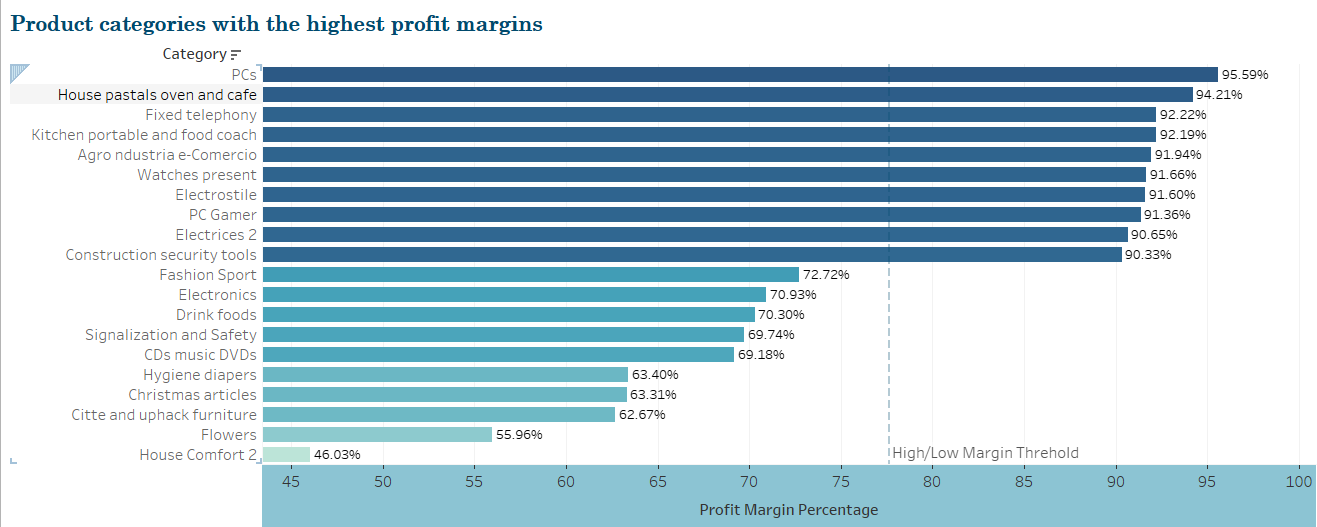

In [5]:
from IPython.display import Image
Image(filename="C:/e-Commerce (Target) Sales/assets/highest_profit_margin.png")

## 2. Product Revenue Contribution and Volume Analysis

*WHY? TO Identify the products driving revenue and the impact of volume vs. price*

*What percentage of revenue comes from the top 20% of products (Pareto Principle)?*

In [6]:
query = '''
SELECT 
    products.product_id, 
    SUM(order_items.price) AS total_sum, 
    products.product_category_name AS category
FROM 
    order_items
JOIN 
    products ON order_items.product_id = products.product_id
GROUP BY 
    products.product_id, products.product_category_name
ORDER BY 
    total_sum DESC;

'''

revenue_df = pd.read_sql(query,conn)
revenue_df

C:\Users\Acer\AppData\Local\Temp\ipykernel_9932\2843871995.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  revenue_df = pd.read_sql(query,conn)


,product_id,total_sum,category
0,bb50f2e236e5eea0100680137654686c,63885.000000,HEALTH BEAUTY
1,6cdd53843498f92890544667809f1595,54730.199280,HEALTH BEAUTY
2,d6160fb7873f184099d9bc95e30376af,48899.339966,PCs
3,d1c427060a0f73f6b889a5c7c61f2ac4,47214.510490,computer accessories
4,99a4788cb24856965c36a24e339b6058,43025.560699,bed table bath
...,...,...,...
32946,2e8316b31db34314f393806fd7b6e185,2.990000,stationary store
32947,680cc8535be7cc69544238c1d6a83fe8,2.900000,pet Shop
32948,8a3254bee785a526d548a81a9bc3c9be,2.550000,Construction Tools Construction
32949,310dc32058903b6416c71faff132df9e,2.290000,stationary store


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

revenue_df['cumulative_revenue'] = revenue_df['total_sum'].cumsum()
revenue_df['cumulative_revenue_percentage'] = (revenue_df['cumulative_revenue'] / revenue_df['total_sum'].sum()) * 100

# Calculate cumulative product percentage
revenue_df['cumulative_products_percentage'] = (revenue_df.index + 1) / len(revenue_df) * 100

# Find the percentage of products that contribute to 80% revenue
top_80_percent = revenue_df[revenue_df['cumulative_revenue_percentage'] <= 80]

print(f"Top 20% Products Contribution to Total Revenue: {len(top_80_percent)} / {len(revenue_df)}")


Top 20% Products Contribution to Total Revenue: 8535 / 32951


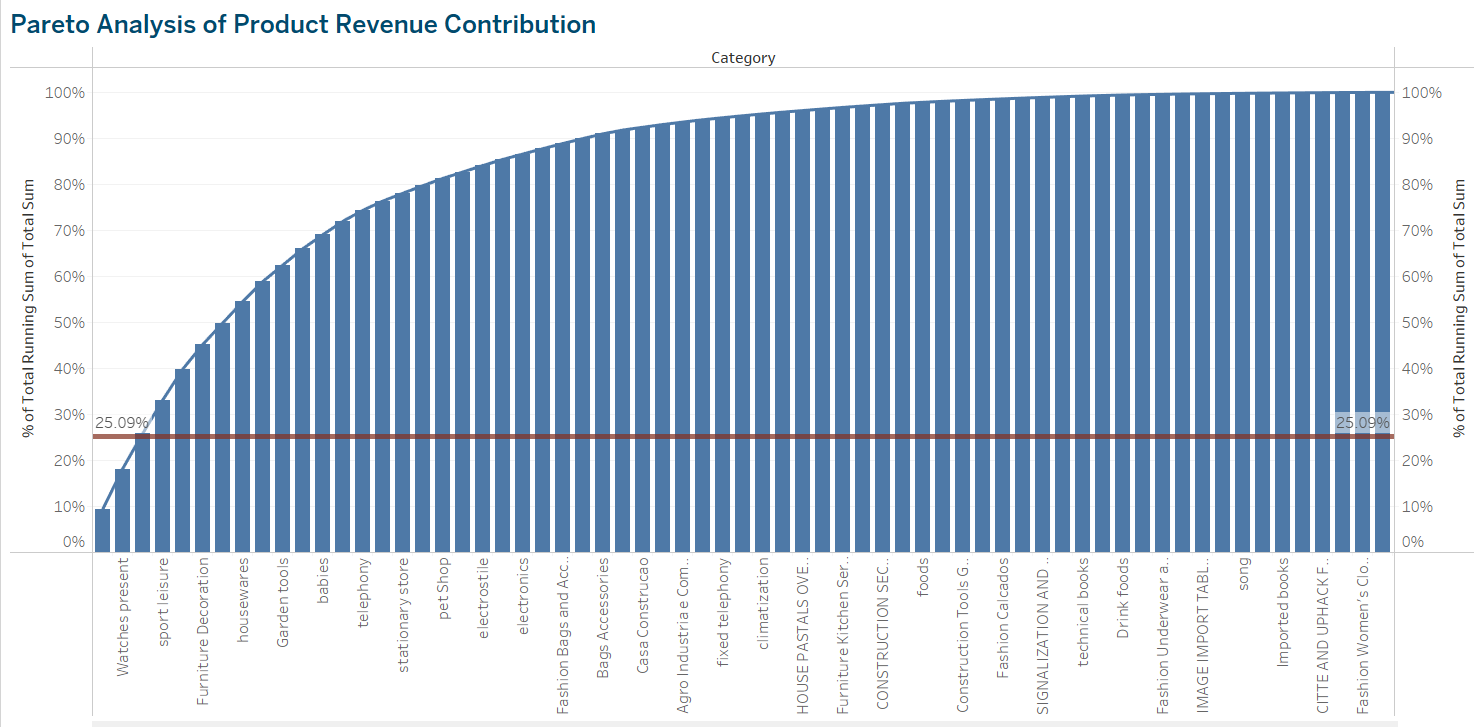

In [8]:
# Export DataFrame to a CSV file
revenue_df.to_csv('cumulative_revenue_data.csv', index=False)
Image(filename="C:/e-Commerce (Target) Sales/assets/pareto.png")


### *Which products generate high revenue but have low order volume?*

WHY? to find out expensive, low-order volume products that require targeted promotion

In [9]:
import pandas as pd

order_items_df = pd.read_sql('SELECT product_id, price, order_id FROM order_items', conn)
products_df = pd.read_sql('SELECT product_id, product_category_name FROM products', conn)
merged_df = order_items_df.merge(products_df, on='product_id')





C:\Users\Acer\AppData\Local\Temp\ipykernel_9932\2932978388.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_items_df = pd.read_sql('SELECT product_id, price, order_id FROM order_items', conn)
C:\Users\Acer\AppData\Local\Temp\ipykernel_9932\2932978388.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  products_df = pd.read_sql('SELECT product_id, product_category_name FROM products', conn)


In [10]:
product_metrics = merged_df.groupby(['product_id', 'product_category_name']).agg(
    total_revenue=('price', 'sum'),
    total_orders=('order_id', 'count'),
    avg_revenue_per_order=('price', 'mean')
).reset_index()



In [11]:


# High order volume but low revenue per order
frequent_low_value = product_metrics[
    (product_metrics['total_orders'] > product_metrics['total_orders'].quantile(0.75)) &
    (product_metrics['avg_revenue_per_order'] < product_metrics['avg_revenue_per_order'].mean())
]



In [12]:

print("\nFrequently Purchased Products with Low Revenue Per Order:")
print(frequent_low_value[['product_category_name', 'total_orders', 'avg_revenue_per_order']])


Frequently Purchased Products with Low Revenue Per Order:
              product_category_name  total_orders  avg_revenue_per_order
7                    Games consoles             9              38.900000
9              Furniture Decoration            14              34.990000
11                    HEALTH BEAUTY             7              33.412857
14                       housewares            11              75.444545
17                       Cool Stuff             6              39.000000
...                             ...           ...                    ...
32928  Fashion Bags and Accessories             8              28.740000
32940               technical books             5              40.000000
32941            Christmas articles             5              31.780000
32942              stationary store             8               7.475000
32949          computer accessories             5              33.990000

[4992 rows x 3 columns]


In [13]:

expensive_low_orders = product_metrics[
    (product_metrics['total_revenue'] > product_metrics['total_revenue'].quantile(0.75)) &
    (product_metrics['total_orders'] < 10)  # Products with fewer than 10 orders
]

print("Expensive Products with Low Orders:")
print(expensive_low_orders[['product_category_name', 'total_revenue', 'total_orders']])



Expensive Products with Low Orders:
                                  product_category_name  total_revenue  \
6                                            Cool Stuff          498.0   
7                                        Games consoles          350.1   
12                                     Fashion Calcados         1618.6   
27                                      Casa Construcao          666.0   
28     Furniture Kitchen Service Area Dinner and Garden          898.0   
...                                                 ...            ...   
32924                                   Watches present         2835.8   
32933                                              toys         1449.0   
32934                                     sport leisure          338.0   
32938                                              toys          750.0   
32945                                   Watches present          818.0   

       total_orders  
6                 2  
7                 9  
12       

In [14]:
import pandas as pd

# Aggregate and analyze categories in expensive_low_orders
expensive_category_analysis = expensive_low_orders.groupby('product_category_name').agg(
    total_revenue=('total_revenue', 'sum'),
    total_products=('product_category_name', 'count')
).reset_index().sort_values(by='total_products', ascending=False)

frequent_low_value_analysis = frequent_low_value.groupby('product_category_name').agg(
    total_orders=('total_orders', 'sum'),
    avg_revenue_per_order=('avg_revenue_per_order', 'mean'),
    total_products=('product_category_name', 'count')
).reset_index().sort_values(by='total_products', ascending=False)

print("Dominant Categories in Expensive Products with Low Orders:")
print(expensive_category_analysis.head(10))

print("\nDominant Categories in Frequently Purchased Products with Low Revenue Per Order:")
print(frequent_low_value_analysis.head(10))


Dominant Categories in Expensive Products with Low Orders:
   product_category_name  total_revenue  total_products
62         sport leisure      469132.54             565
42       Watches present      570146.60             559
46        bed table bath      308348.38             474
28         HEALTH BEAUTY      454073.79             468
49  computer accessories      329779.79             371
22  Furniture Decoration      233832.77             349
44            automotive      275067.69             348
56            housewares      229060.77             300
66                  toys      223346.63             274
13            Cool Stuff      249260.66             255

Dominant Categories in Frequently Purchased Products with Low Revenue Per Order:
   product_category_name  total_orders  avg_revenue_per_order  total_products
45        bed table bath          6690              66.995537             564
62         sport leisure          4400              68.800053             425
57       

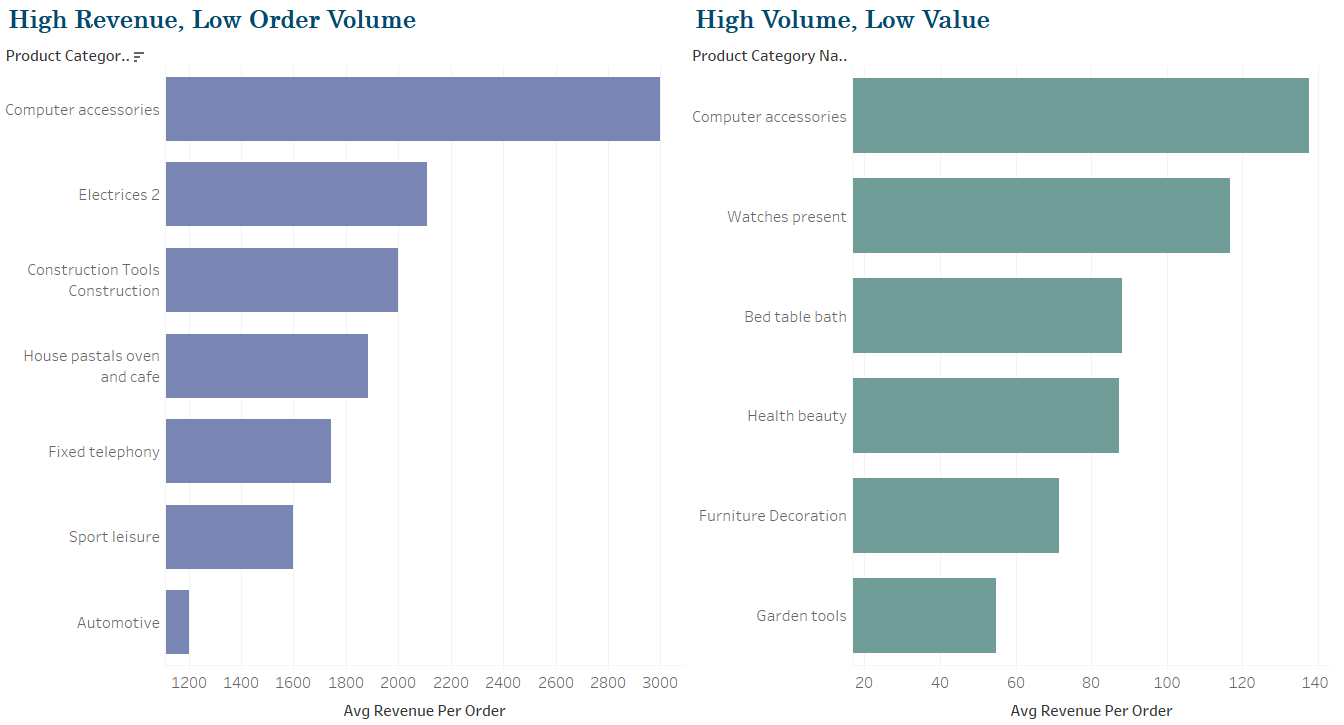

In [15]:
Image(filename="assets/comparison.png")

## 3. Payment Preferences and Revenue Contribution

WHY? In order to analyze which payment methods dominate revenue and how installments contribute

#*What are the most common payment methods?*

In [16]:
query = '''
SELECT 
    payment_type, 
    COUNT(payment_type) AS payments_count,
    SUM(payment_value) AS total_payment_value
FROM payments
GROUP BY payment_type
ORDER BY total_payment_value
'''

payment_df = pd.read_sql(query,conn)
payment_df

C:\Users\Acer\AppData\Local\Temp\ipykernel_9932\364083006.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  payment_df = pd.read_sql(query,conn)


,payment_type,payments_count,total_payment_value
0,not_defined,6,0.000000e+00
1,debit_card,3058,4.359796e+05
2,voucher,11550,7.588737e+05
3,UPI,39568,5.738723e+06
4,credit_card,153590,2.508417e+07


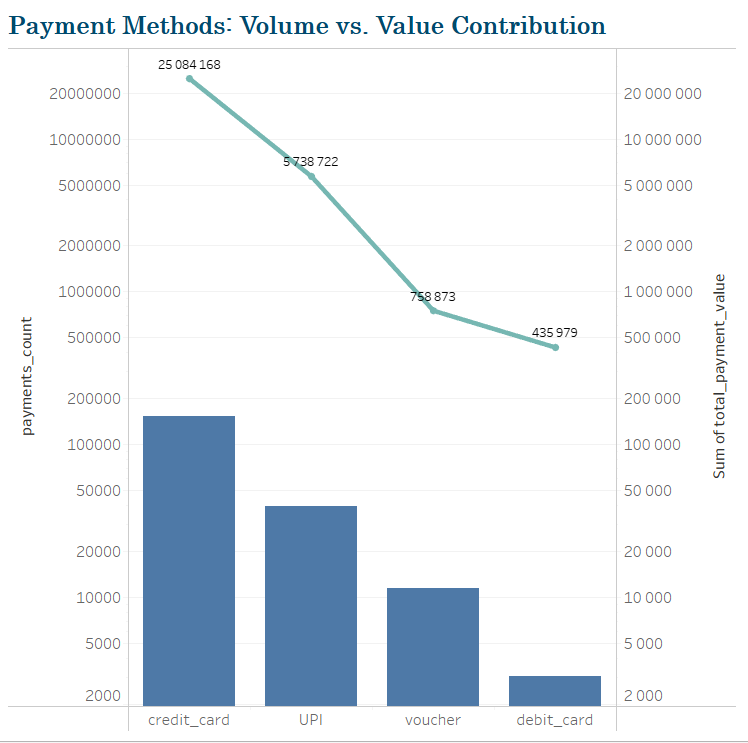

In [19]:

Image(filename="C:/e-Commerce (Target) Sales/assets/payment_methods.png")


### *How many payments are made in installments vs single payments?*

In [22]:
query = '''
SELECT 
    COUNT(*) AS installment_payments_count,
    SUM(payment_value) AS total_installment_payment_value,
    ROUND(AVG(payment_installments), 2) AS avg_installment_count
FROM payments
WHERE payment_installments > 1;


'''

installments_df = pd.read_sql(query, conn)
installments_df

C:\Users\Acer\AppData\Local\Temp\ipykernel_9932\3258209803.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  installments_df = pd.read_sql(query, conn)


,installment_payments_count,total_installment_payment_value,avg_installment_count
0,102676,2.020290e+07,4.75


In [28]:
query = '''
SELECT 
    CASE 
        WHEN payment_installments > 1 THEN 'Installments'
        ELSE 'Single Payment'
    END AS payment_type,
    COUNT(*) AS payment_count,
    SUM(payment_value) AS total_payment_value
FROM payments
GROUP BY 
    CASE 
        WHEN payment_installments > 1 THEN 'Installments'
        ELSE 'Single Payment'
    END;

'''

installments2_df = pd.read_sql(query, conn)


C:\Users\Acer\AppData\Local\Temp\ipykernel_9932\1793155664.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  installments2_df = pd.read_sql(query, conn)


In [29]:

installments_comparison = pd.DataFrame(installments2_df)
installments_comparison['total_payment_value'] = installments_comparison['total_payment_value'].apply(lambda x: f"{x:,.0f}")

installments_comparison


,payment_type,payment_count,total_payment_value
0,Installments,102676,"20,202,900"
1,Single Payment,105096,"11,814,844"


C:\Users\Acer\AppData\Local\Temp\ipykernel_9932\2174714299.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  payments_df = pd.read_sql('SELECT payment_installments, payment_value FROM payments', conn)


Correlation between total payment value and payment installments: 0.33


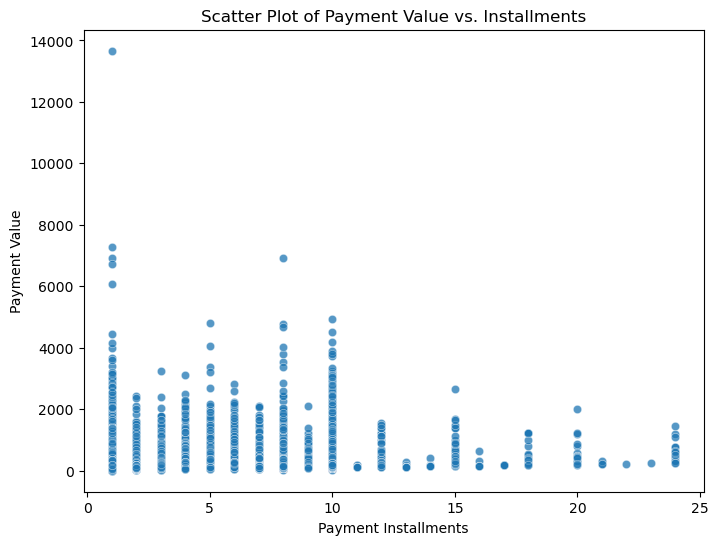

In [33]:


# Load the original payments data with payment_installments
payments_df = pd.read_sql('SELECT payment_installments, payment_value FROM payments', conn)

# Convert columns to numeric types
payments_df['payment_installments'] = pd.to_numeric(payments_df['payment_installments'], errors='coerce')
payments_df['payment_value'] = pd.to_numeric(payments_df['payment_value'], errors='coerce')

# Drop any NaN or zero values
payments_df = payments_df.dropna()
payments_df = payments_df[(payments_df['payment_installments'] > 0) & (payments_df['payment_value'] > 0)]

# Calculate correlation
correlation = payments_df['payment_value'].corr(payments_df['payment_installments'])
print(f"Correlation between total payment value and payment installments: {correlation:.2f}")

# Visualize the relationship
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(data=payments_df, x='payment_installments', y='payment_value', alpha=0.5)
plt.title('Scatter Plot of Payment Value vs. Installments')
plt.xlabel('Payment Installments')
plt.ylabel('Payment Value')
plt.show()




The lack of correlation means not every installment is tied to a large purchase, but installments enable larger purchases more frequently than single payments, resulting in a higher total value.